In [7]:
import ee


In [8]:
ee.Initialize()

In [9]:
import geemap
import ipyleaflet
import numpy as np

In [10]:
## specify areas of interest / districts and metadata
Districts = ee.FeatureCollection('users/emackres/Wards/Addis_Ababa_Woredas')

Areaofinterest = "ETH-Addis_Ababa" ## 3-letter country abreviation - city name with underscore for spaces, e.g. "ETH-Addis_Ababa"
unitofanalysis = "ADM4" ## options: "ADM0" (country), "ADM1" (state), "Metro" (metropolitan region), "ADM2" (municipality), "ADM3" (subcity/locality), "ADM4"(ward/neighborhood), ideally align with https://www.geoboundaries.org/index.html#getdata


#print(Districts.limit(1).getInfo())

In [11]:
## create map
Map = geemap.Map(height="400px")
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [12]:
## add basemap and center on area of interest
Map.add_basemap('HYBRID')
Map.centerObject(Districts, zoom=12)

In [13]:
## GLAD land cover change datasets
LCLUC2000 = ee.Image('projects/glad/GLCLU2020/LCLUC_2000')
LCLUC2020 = ee.Image('projects/glad/GLCLU2020/LCLUC_2020')
LCLUCchange = ee.Image('projects/glad/GLCLU2020/LCLUC')

# simplify the taxonomy 
def simplifyLC(im):
    im = ee.Image(im)
    im=(im.where(im.eq(0),0)
    .where(im.gte(1).And(im.lte(24)),1)
    .where(im.gte(25).And(im.lte(41)),2)
    .where(im.gte(42).And(im.lte(48)),3)
    .where(im.gte(100).And(im.lte(124)),4)
    .where(im.gte(125).And(im.lte(148)),5)
    .where(im.gte(200).And(im.lte(207)),6)
    .where(im.eq(241),7)
    .where(im.eq(244),8)
    .where(im.eq(250),9)
    .where(im.eq(255),10)
           )
    return im.updateMask(im.lte(9).And(im.gte(0)))

LC2000 = simplifyLC(LCLUC2000)
LC2020 = simplifyLC(LCLUC2020)

LCproj = LC2020.projection().nominalScale()
print(LC2000.getInfo())
print(LCproj.getInfo())

{'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [1440000, 560000], 'crs': 'EPSG:4326', 'crs_transform': [0.00025, 0, -180, 0, -0.00025, 80]}], 'version': 1637178488282607, 'id': 'projects/glad/GLCLU2020/LCLUC_2000', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 72113993672}}
27.829872698318393


In [14]:
## define styling and legend 

LCLUCclasses = [
"Bare Ground",
"Short Vegetation",
"Forest",
"Tall Forest (20m+)",
"Wetland - Short Vegetation",
"Wetland - Forest",
"Water",
"Snow/Ice",
"Cropland",
"Built-up Area"
  ]

LCLUCcolors = [
"FEFECC",
"B9B91E",
"347834",
"0D570D",
"88CAAD",
"589558",
"6BAED6",
"ACD1E8",
"FFF183",
"E8765D"
  ]

# add to map
vizLC = {'min':0, 'max':9, 'palette': LCLUCcolors}
Map.addLayer(LC2000,vizLC,"LCLUC 2000 (UMD)")
Map.addLayer(LC2020,vizLC,"LCLUC 2020 (UMD)")

Map.add_legend(legend_keys=LCLUCclasses, legend_colors=LCLUCcolors, position='bottomleft')


In [17]:
# create images with habitat and non-habitat classes in each year

def habitatLC(im):
    im = ee.Image(im)
    im = (im.where(im.eq(0),0)
            .where(im.gte(7).And(im.lte(9)),0)
            .where(im.gte(1).And(im.lte(6)),1)
           )
    return im.updateMask(im.gte(0).And(im.lte(1)))

Hab2000 = habitatLC(LC2000)
Hab2020 = habitatLC(LC2020)

print(Hab2000.getInfo())

vizHab = {'min':0, 'max':1, 'palette': ['black','white']}

Map.addLayer(Hab2000,vizHab,"Habitat 2000")
Map.addLayer(Hab2020,vizHab,"Habitat 2020")

{'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [1440000, 560000], 'crs': 'EPSG:4326', 'crs_transform': [0.00025, 0, -180, 0, -0.00025, 80]}], 'version': 1637178488282607, 'id': 'projects/glad/GLCLU2020/LCLUC_2000', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 72113993672}}


In [18]:
# create image with habitat gains and losses between start and end years
def change(start, end):
    im = (start.where(start.eq(0).And(end.eq(0)),0)
            .where(start.eq(1).And(end.eq(1)),0)
            .where(start.eq(0).And(end.eq(1)),1)
            .where(start.eq(1).And(end.eq(0)),-1)
           )
    return im.updateMask(im.gte(-1).And(im.lte(1)).And(im.neq(0)))

HabChange = change(Hab2000,Hab2020)
print(HabChange.getInfo())

vizCh = {'min':-1, 'max':1, 'palette': ['red','white','green']}
Map.addLayer(HabChange,vizCh,'Habitat change')

{'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -1, 'max': 255}, 'dimensions': [1440000, 560000], 'crs': 'EPSG:4326', 'crs_transform': [0.00025, 0, -180, 0, -0.00025, 80]}], 'version': 1637178488282607, 'id': 'projects/glad/GLCLU2020/LCLUC_2000', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 72113993672}}


In [19]:
## Define masks for count operations
NonHab2000masked = Hab2000.updateMask(Hab2000.eq(0))
HabGain2020masked = HabChange.updateMask(HabChange.eq(1))
Habtypes2020 = LC2020.updateMask(Hab2020.eq(1))
NewHabtypes2020 = LC2020.updateMask(HabChange.eq(1))
#Map.addLayer(NewHabtypes2020,vizLC,"mask")

In [20]:
## reduce image counts to featurecollection of districts

histo=HabGain2020masked.reduceRegions(
  reducer= ee.Reducer.count().setOutputs(["count_gain2020"]),
  collection= Districts, 
  scale= 30, 
  tileScale= 1
)

histo=NonHab2000masked.reduceRegions(
  reducer= ee.Reducer.count().setOutputs(["count_nonhab2000"]), 
  collection= histo, 
  scale= 30, 
  tileScale= 1
)

histo=Habtypes2020.reduceRegions(
  reducer= ee.Reducer.countDistinctNonNull().setOutputs(["countD_habtypes2020"]), 
  collection= histo, 
  scale= 30, 
  tileScale= 1
)

histo=NewHabtypes2020.reduceRegions(
  reducer= ee.Reducer.countDistinctNonNull().setOutputs(["countD_newhabtypes2020"]), 
  collection= histo, 
  scale= 30, 
  tileScale= 1
)

print('histo:', histo.limit(1).getInfo())

histo: {'type': 'FeatureCollection', 'columns': {'Area_ha': 'Float', 'Id': 'Integer', 'Sub_City': 'String', 'Woreda': 'String', 'area_m2': 'Float', 'countD_habtypes2020': 'Long<0, 4294967295>', 'countD_newhabtypes2020': 'Long<0, 4294967295>', 'count_gain2020': 'Long<0, 4294967295>', 'count_nonhab2000': 'Long<0, 4294967295>', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[38.76417387244602, 8.976616316802497], [38.7641916825425, 8.976406781941595], [38.76425413764042, 8.976264058425187], [38.76430317523276, 8.976201645102348], [38.76441914020607, 8.976148106823914], [38.76458853494989, 8.97616598790578], [38.76476695401838, 8.976223929389619], [38.76493634785494, 8.976237280533844], [38.764989857367304, 8.976241776310136], [38.765203894975826, 8.976179326382345], [38.7652708215161, 8.97610797413942], [38.76527529393161, 8.976103508826643], [38.7655026679355, 8.975835994819104], [38.76559187627525, 8.975590728116439], [38.765

In [21]:
# convert counts to indicators and create new featurecollection

def count_to_stats(feat):
    feat=ee.Feature(feat)
    
    HabRestPct = feat.getNumber('count_gain2020').divide(feat.getNumber('count_nonhab2000'))
    HabTypesRestPct = feat.getNumber('countD_newhabtypes2020').divide(feat.getNumber('countD_habtypes2020'))
    #HabRestArea = feat.getNumber('count_gain2020').multiply(ee.Number(30)).multiply(ee.Number(30)).multiply(ee.Number(0.000001))
    HabRestArea = feat.getNumber('count_gain2020').multiply(ee.Number(LCproj)).multiply(ee.Number(LCproj)).multiply(ee.Number(0.000001))

    FeatArea = feat.area().multiply(0.000001)
    cityID = Areaofinterest
    geo_level = unitofanalysis
    geo_name = feat.getString("Sub_City").cat(ee.String("-")).cat(feat.getString("Woreda"))
    geo_id = ee.String(cityID+"-").cat(geo_name)
    year = 2020
    source = "GLAD LCLUC"
    
    return feat.set({
        'SICB-7A-HabRestoredPct2000-2020': HabRestPct,
        'TotalareaKM2': FeatArea,
        'SICB-7B-HabTypesRestoredPct2000-2020': HabTypesRestPct,
        'HabRestAreaKM2-2000-2020': HabRestArea,
        'geo_level': geo_level,
        'geo_name': geo_name,
        'geo_id': geo_id,
        'year':year,
        'source':source,
    })

HabGainPcts=histo.map(count_to_stats)

# keep only properties desired for the output file. 
HabGainPcts=HabGainPcts.select([
    'SICB-7A-HabRestoredPct2000-2020',
    'TotalareaKM2',
    'SICB-7B-HabTypesRestoredPct2000-2020',
    'HabRestAreaKM2-2000-2020',
    'geo_level',
    'geo_name',
    'geo_id',
    'year',
    'source'])
print(HabGainPcts.limit(1).getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[38.76417387244602, 8.976616316802497], [38.7641916825425, 8.976406781941595], [38.76425413764042, 8.976264058425187], [38.76430317523276, 8.976201645102348], [38.76441914020607, 8.976148106823914], [38.76458853494989, 8.97616598790578], [38.76476695401838, 8.976223929389619], [38.76493634785494, 8.976237280533844], [38.764989857367304, 8.976241776310136], [38.765203894975826, 8.976179326382345], [38.7652708215161, 8.97610797413942], [38.76527529393161, 8.976103508826643], [38.7655026679355, 8.975835994819104], [38.76559187627525, 8.975590728116439], [38.7657122314687, 8.975363294742397], [38.76587723032956, 8.97506905440436], [38.76601100208955, 8.974823768103722], [38.76612249165628, 8.974627563292099], [38.76618494489727, 8.974596365196794], [38.76618941724983, 8.97460082150302], [38.766251790563075, 8.974614171691316], [38.766309771335756, 8.974667731290303

In [22]:
## render on map percent tree cover by class from feature collection

empty = ee.Image().byte()
Tpctfills = empty.paint(**{'featureCollection': HabGainPcts,'color': 'SICB-7B-HabTypesRestoredPct2000-2020'})
Tpctfills2 = empty.paint(**{'featureCollection': HabGainPcts,'color': 'SICB-7A-HabRestoredPct2000-2020'})

fillspalette = ['red', 'green']
Map.addLayer(Tpctfills, {'palette': fillspalette,'min':0,'max':1}, '% habitat types restored (2000-2020)', True, 0.65)
Map.addLayer(Tpctfills2, {'palette': fillspalette,'min':0,'max':0.15}, '% habitat restored (2000-2020)', True, 0.65)
Map

Map(bottom=498221.0, center=[8.98091786068599, 38.78520904303285], controls=(WidgetControl(options=['position'…

In [27]:
## display features in chart

import geemap.chart as chart

xProperty = "geo_name" #,"Woreda"
yProperties = ['SICB-7A-HabRestoredPct2000-2020'] # ,'LC50areaKM2'

options = {
    'xlabel': "geo_name",
    'ylabel': "% habitat restored (2000-2020)",
    "legend_location": "top-right",
    "height": "500px",
}

chart.feature_byFeature(HabGainPcts, xProperty, yProperties, **options)

In [23]:
df = geemap.ee_to_pandas(HabGainPcts)
df = df.sort_values(by=['SICB-7A-HabRestoredPct2000-2020'],axis='index',ascending=False)
df

,SICB-7B-HabTypesRestoredPct2000-2020,year,TotalareaKM2,geo_level,SICB-7A-HabRestoredPct2000-2020,source,HabRestAreaKM2-2000-2020,geo_name,geo_id
11,1.0,2020,24.699486,ADM4,0.134844,GLAD LCLUC,1.765090,Bole-12,ETH-Addis_Ababa-Bole-12
40,1.0,2020,3.510539,ADM4,0.104435,GLAD LCLUC,0.113077,Gulele-06,ETH-Addis_Ababa-Gulele-06
10,1.0,2020,27.260199,ADM4,0.096724,GLAD LCLUC,1.786001,Bole-11,ETH-Addis_Ababa-Bole-11
80,1.0,2020,12.839059,ADM4,0.083258,GLAD LCLUC,0.783021,Akaki Akality-10,ETH-Addis_Ababa-Akaki Akality-10
86,1.0,2020,13.323004,ADM4,0.075895,GLAD LCLUC,0.730355,Akaki Akality-04,ETH-Addis_Ababa-Akaki Akality-04
...,...,...,...,...,...,...,...,...,...
53,0.0,2020,1.625646,ADM4,0.000000,GLAD LCLUC,0.000000,Kirkos-04,ETH-Addis_Ababa-Kirkos-04
52,0.0,2020,1.957565,ADM4,0.000000,GLAD LCLUC,0.000000,Kirkos-02,ETH-Addis_Ababa-Kirkos-02
51,0.0,2020,1.330559,ADM4,0.000000,GLAD LCLUC,0.000000,Kirkos-03,ETH-Addis_Ababa-Kirkos-03
50,0.0,2020,0.717217,ADM4,0.000000,GLAD LCLUC,0.000000,Kirkos-11,ETH-Addis_Ababa-Kirkos-11


<AxesSubplot:xlabel='geo_name'>

<Figure size 432x288 with 0 Axes>

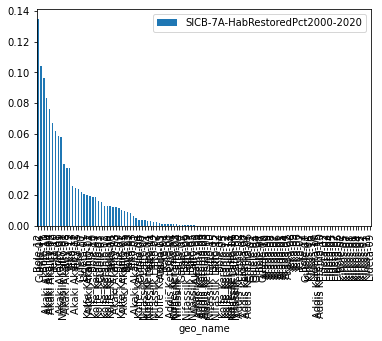

In [26]:
import matplotlib.pyplot as plt
plt.close("all")
import pandas as pd


plt.figure();

df.plot.bar(x="geo_name", y="SICB-7A-HabRestoredPct2000-2020")


Download/export options

In [279]:
# Download attribute table as a CSV
url = HabGainPcts.getDownloadURL(
    filetype="csv",
    filename="HabGainPcts",
)
print("CSV",url)

# Download attribute table as a GeoJSON
url = HabGainPcts.getDownloadURL(
    filetype="GEOJSON",
    filename="HabGainPcts",
)
print("GeoJSON",url)

CSV https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/3f16b2532d9fd798f0a466ab27c0e42d-df7fc70d2f9a0f83c4d7f51304d5fc0d:getFeatures
GeoJSON https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/b6f17b6d519d24a31c7421b9800551bf-92ca16ad5b6633311916c47e40f89427:getFeatures


In [293]:
# Download Land cover rasters
url = LC2000.getDownloadURL({
    'format':"GEO_TIFF",
    'name':"GLADlandcover2000.tif",
    'region':Districts.geometry(),
    'filePerBand':True,
    'scale':30}
)
print("GEOTIFF 2000",url)

url = LC2020.getDownloadURL({
    'format':"GEO_TIFF",
    'name':"GLADlandcover2020.tif",
    'region':Districts.geometry(),
    'filePerBand':True,
    'scale':30}
)
print("GEOTIFF 2020",url)

GEOTIFF 2000 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14667adeb8d92c38b7a8a20bcde9b95e-75fe714a041f6914b95d9ce82b32c29c:getPixels
GEOTIFF 2020 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/69785c87dea85fdbb6da34f4ad8df343-0d52ef0ca7ef9be0bd35d814b229d66c:getPixels


In [280]:
# Alternative download ee.Image for Land cover as GeoTIFF

geemap.ee_export_image(
    LC2000, filename="GLADlandcover2000.tif", scale=30, region=Districts.geometry(), file_per_band=False
)

geemap.ee_export_image(
    LC2000, filename="GLADlandcover2020.tif", scale=30, region=Districts.geometry(), file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Eric.Mackres.INTERNAL\OneDrive - World Resources Institute\Python Scripts\GLADlandcover2000.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Eric.Mackres.INTERNAL\OneDrive - World Resources Institute\Python Scripts\GLADlandcover2020.tif
